# Probabilistic Reasoning

## Exercise 1: Follow the robot

Assume you get your hands on a robot that has various sensors.

**a)** *The robot has a very cheap camera on board, so it's not very accurate at reading colors. After color calibration you know the camera color model. Assume the robot is located in a white room with 5 boxes: 2 red, 2 green and a blue one. The robot moves towards a box and the camera reads green. How likely is it that the box is actually green?*

Let us first write down the color mapping.

In [22]:
import pandas as pd

color_model = pd.DataFrame({'R': [0.8, 0.1, 0.1], 
                            'G': [0.1, 0.6, 0.3], 
                            'B': [0.1, 0.2, 0.7]}, index=['R', 'G', 'B'])
color_model

,R,G,B
R,0.8,0.1,0.1
G,0.1,0.6,0.2
B,0.1,0.3,0.7


The quantities of the boxes are:

In [23]:
quantities = pd.Series({'R': 2, 'G': 2, 'B': 1}, index=None)
quantities

R    2
G    2
B    1
dtype: int64

To compute the probability we are interested in, we will use Bayes' rule:

**Notation:**
We will use $X$ as the variable for the true color and $Z$ as the variable for the color read by the camera.

Thus, what we want to compute is $p(X=G|Z=G)$. But that is difficult to obtain. Easier to compute is $p(Z=G|X=G)$.

Bayes' rule says that:

$$ p(a|b) = \frac{ p(b|a) \cdot p(a)}{p(b)} $$

Converting it to our need, we have:

$$p(X=G|Z=G) = \frac{p(Z=G|X=G) \cdot p(X=G)}{p(Z=G)}$$

Now let's compute each term on the RHS:

The term $p(Z=G|X=G)$ is the <b>likelihood</b> and is exactly why we need a sensor model.

In [24]:
color_model

,R,G,B
R,0.8,0.1,0.1
G,0.1,0.6,0.2
B,0.1,0.3,0.7


In [25]:
likelihood_gg = color_model.loc['G', 'G']
likelihood_gg

0.6

The second term $p(X=G)$ is the <b>prior</b> (no sensor input!). In this case we know the prior exactly: $$p(X=G) = \frac{n_G}{n_R + n_G + n_B} = \frac{2}{5}$$

In [26]:
quantities

R    2
G    2
B    1
dtype: int64

In [27]:
quantities/quantities.sum()

R    0.4
G    0.4
B    0.2
dtype: float64

In [28]:
prior_g = quantities['G'] / quantities.sum()
prior_g

0.4

The denominator $p(Z=G)$ is the <b>normalizer</b> and we compute it by **marginalization**, 

a.k.a. by summing up the (likelihood * prior) products for **all possibilities** regarding the true color:

$$p(Z=G) = \sum_{x \in \{R,G,B\}} p(Z=G|X=x)p(X=x)$$

$$ \Rightarrow p(X=G|Z=G) = \frac{ p(Z=G|X=G)p(X=G) }{\sum_{x \in \{R,G,B\}} p(Z=G|X=x)p(X=x)} $$

<i> Note that marginalizing here is easy because we have a small finite set of possibilities. 
In many problems however, the normalizer is very expensive to compute and we resort to tools like approximation (e.g. by sampling).</i>

The first vector $p(Z=G|X)$ can be read from the color model, a.k.a. the row that corresponds to observing "green".

In words, it is the likelihood of reading "green" given the true color.

In [29]:
color_model

,R,G,B
R,0.8,0.1,0.1
G,0.1,0.6,0.2
B,0.1,0.3,0.7


In [30]:
likelihoods_g = color_model.loc['G']
likelihoods_g

R    0.1
G    0.6
B    0.2
Name: G, dtype: float64

The second vector $p(X)$ is just the prior probability of each color:

In [31]:
priors = quantities / quantities.sum()
priors

R    0.4
G    0.4
B    0.2
dtype: float64

Having the likelihoods $p(Z=G|X)$ and the priors $p(X)$, we can compute $$p(Z=G) = \sum_{x \in \{R,G,B\}} p(Z=G|X=x)p(X=x)$$

In practice, the normalizer can be written as inner product between two vectors: 

$$ p(Z=G) = \langle p(Z=G|X), p(X) \rangle  $$



Therefore, the normalizer $p(Z=G)$, a.k.a. the probability of sensing green is:

In [32]:
import numpy as np

normalizer_g = np.dot(likelihoods_g, priors)
normalizer_g

0.32

Now we have everything we need to apply Bayes' rule:

In [33]:
p_gg = likelihood_gg * prior_g / normalizer_g
p_gg

0.75

**b)** *The robot has a proximity sensor and it uses it to measure its distance from a door. The sensor can be modeled using a continuous random variable
with a Normal distribution with $\sigma_1 = 0.3$. Express the sensor model $p(z_t|x_t)$ in the
full form (not the shorthand notation).*

$$ p(z_t|x_t) = \cal{N} (z_t ; x_t, \sigma_1^2)
= \frac{1}{\sigma_1\sqrt{2\pi}} \exp \left( - \frac{(z_t-x_t)^2}{2\sigma_1^2} \right) 
= \frac{1}{0.3\sqrt{2\pi}} \exp \left( - \frac{(z_t-x_t)^2}{2 \cdot 0.3^2} \right) $$

In [34]:
import matplotlib.pyplot as plt

In [35]:
dx = 0.02
xmin = 0.
xmax = 5.
space = np.arange(xmin, xmax, dx)
sigma1 = 0.3

In [36]:
# Assume the robot is somewhere
x_robot = 2.3

In [37]:
def normal_pdf(x, mu, var):
    return np.exp(-(x - mu)**2 / (2 * var)) / np.sqrt(2*np.pi*var)
    

In [38]:
p_zx = normal_pdf(space, mu=x_robot, var=sigma1**2)

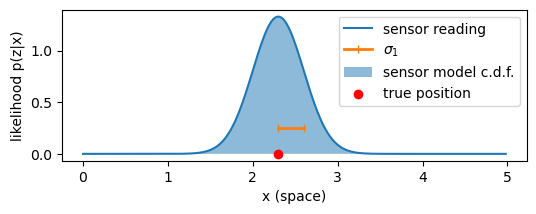

In [39]:
plt.figure(dpi=100, figsize=(6, 2))
plt.plot(space, p_zx, label='sensor reading')
plt.fill_between(space, p_zx, label='sensor model c.d.f.', alpha=0.5)
plt.scatter(x_robot, y=0, label='true position', color='r')
plt.plot([x_robot, x_robot + sigma1], [0.25, 0.25], label='$\sigma_1$', lw=2, marker='|')
plt.xlabel('x (space)')
plt.ylabel('likelihood p(z|x)')
plt.legend()

Why can the likelihood get values greater than 1 ?

p(z|x) is a p.d.f. (probability density function).

What sums up to 1 is its integral (the area under the curve) - the c.d.f.

In [40]:
np.sum(p_zx * dx)

0.9999999999999932

**c)** *Now the robot moves into a hallway. Initially it knows it is located
at the door ($x_0=0$). The robot can execute move commands but the result of the
action is not always perfect. Assume that the robot receives a command $u_t$ at each time step to move with constant speed $v$.
The motion can also be modeled with a Gaussian with deviation $\sigma_2 = 0.1$. Write
the motion model $p(x_t|x_{t-1}, u_t)$.*

The motion can also be modeled with a Gaussian. We just need to think about what
is our mean and what is our variance. The variance is the square of the standard deviation which is given as the actuator noise
$\sigma_2 = 0.1$. Our mean is the expected position of the robot after the motion
$u_t$. Since our robot moves with constant speed $v$, the expected position is simply $\mu = x_{t-1} + v \Delta t$. Therefore we have

$$ p(x_t|x_{t-1}, u_t) = \cal{N} (x_t; x_{t-1} + v \Delta t, \sigma_2^2) $$

$$
= \frac{1}{\sigma_2 \sqrt{2\pi}} \exp \left( - \frac{(x_t - (x_{t-1}+ v \Delta t))^2}{2\sigma_2^2} \right) $$

$$
= \frac{1}{0.1\sqrt{2\pi}} \exp \left( - \frac{(x_t - (x_{t-1}+ v \Delta t))^2}{2 \cdot 0.1^2} \right) $$

In [19]:
x0 = 0
dt = 0.2
v = 6
sigma2 = 0.1

In [20]:
mu = x0 + v * dt
p_trans01 = normal_pdf(space, mu, sigma2**2)

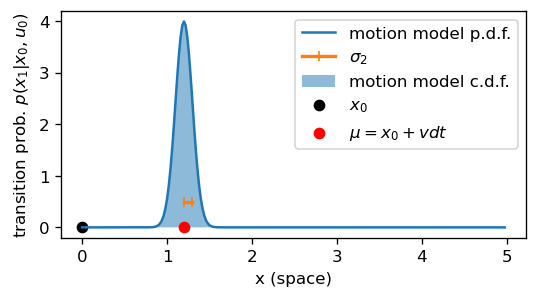

In [21]:
plt.figure(dpi=120, figsize=(5, 2.5))
plt.plot(space, p_trans01, label='motion model p.d.f.')
plt.fill_between(space, p_trans01, label='motion model c.d.f.', alpha=0.5)
plt.scatter(x0, y=0, label='$x_0$', color='k')
plt.scatter(mu, y=0, label='$\mu = x_0 + v dt$', color='r')
plt.plot([mu, mu + sigma2], [0.5, 0.5], label='$\sigma_2$', lw=2, marker='|')
plt.xlabel('x (space)')
plt.ylabel('transition prob. $p(x_1|x_0, u_0)$')
plt.legend()

**d)** *You let the robot run with a speed of 1 m/s. The robot only runs
forward and it updates its belief every second. Assume you get the following sensor
measurements in the first 3 seconds: $\{z_1 = 1.2, z_2 = 1.6, z_3 = 2.5\}$.
Further assume that the hallway is only 5 meters long. Where
does the robot believe it is located with respect to the door after 3 seconds? How
certain is it about its location? Try out different standard deviations for the sensor and the motion model. How does it affect the robot's belief?*

We model the state variable $x$ as a continuous random variable with values between 0 and 5, where 0 means that the robot is at the door. We want to compute the robot’s belief. Initially, the robot knows it is located at the door ($x_0=0$), therefore we have $bel(x_0 = 0) = +\infty$. We then use the Bayes Filter algorithm to compute the belief after 3 seconds, namely $bel(x_3)$. We compute the belief at each time step. The general equation of the Bayes filter is:

$$ bel(x_t) = \eta_t \cdot p(z_t|x_t) \cdot \int p(x_t | x_{t-1}, u_t) \cdot bel(x_{t-1}) dx_{t-1} $$

In our case the space can be reduced to an interval from 0 to 5, so we get a definite integral. Furthermore, there is only one action $u$ that is taken at every time step, which is to move with constant speed 1 m/s.
Let us see how we would compute the belief after one second:

$$ bel(x_1) = \eta_1 \cdot p(z_1|x_1) \cdot \int_{0}^5 p(x_1 | x_{0}, u) \cdot bel(x_{0}) dx_0 $$ 

which reduces to $$ bel(x_1) = \eta_1 \cdot p(z_1|x_1) \cdot p(x_1 | x_{0}=0, u)  $$

We have the sensor model from question 1b and the motion model from question 1c, so we can substitute with the normal distributions:

$$ p(z_1|x_1) = \frac{1}{0.3\sqrt{2\pi}} \exp \left( - \frac{(1.2-x_1)^2}{2 \cdot 0.3^2} \right) $$
              
$$ p(x_1 | x_0, u) = \frac{1}{0.1\sqrt{2\pi}} \exp \left( - \frac{(x_1 - (0 + 1 \cdot 1))^2}{2 \cdot 0.1^2} \right) $$

$$ \eta_1 = \left( \int_0^5 p(z_1=1.2|x_1) \cdot p(x_1|x_0=0, u) dx_1 \right)^{-1} $$

In our example, the sensor model and the action model are both represented by (one-dimensional) Gaussian pdfs. This is a particular instance of a family of Bayes Filter algorithms, the **Kalman Filter**. The great advantage of the Kalman Filter is that we can do all computations in closed form:

The computation of the belief can be split in two steps:

the *control update* $$ \overline{bel(x_t)} = \int p(x_t | x_{t-1}, u_t) \cdot bel(x_{t-1}) dx_{t-1} $$
    
and the *measurement update* $$bel(x_t) = \eta_t \cdot p(z_t|x_t) \cdot \overline{bel(x_t)}$$

Consider the displacement $\Delta x := x_t - x_{t-1}$. This is a random variable with distribution $p(\Delta x) = \cal N(\Delta x ; v \Delta t, \sigma_1^2)$.

The control update is basically a convolution of the belief $bel(x_{t-1})$ with the displacement distribution:

$$ \int p(x_t | x_{t-1}, u_t) \cdot bel(x_{t-1}) dx_{t-1} =  \int \cal N(\Delta x + x_{t-1} ; v \Delta t + x_{t-1}, \sigma_1^2) \cdot bel(x_{t-1}) dx_{t-1} = \cal N(\Delta x ; v \Delta t, \sigma_1^2) * bel(x_{t-1}) $$

The convolution of two Gaussian pdfs results in another Gaussian pdf. We can compute the parameters of this new Gaussian in closed form:

$$ \cal N(x ; \mu_f, \sigma_f^2) * \cal N(x ; \mu_g, \sigma_g^2) = \cal N (x ; \mu_f + \mu_g, \sigma_f^2 + \sigma_g^2) $$

Assuming a Gaussian belief distribution, in our case:
$$ \overline{bel(x_t)} = \cal N(x ; \mu_{t-1} + v \Delta t, \sigma_{t-1}^2 + \sigma_1^2)$$ 

Thus, the *measurement update* is a product of two Gaussian pdfs. It is easy to verify that this product is proportional to a Gaussian pdf:

$$ \cal N(x ; \mu_f, \sigma_f^2) \cdot \cal N(x ; \mu_g, \sigma_g^2) = s \cdot \cal N \left( x ; \frac{\sigma_g^2 \mu_f + \sigma_f^2 \mu_g}{\sigma_f^2 + \sigma_g^2}, \frac{\sigma_f^2 \sigma_g^2}{\sigma_f^2 + \sigma_g^2} \right) $$

for some scaling factor $s$. Therefore, we know that in order to normalize the belief after each measurement, we need a factor $\eta = s^{-1}$ to get a pdf again.

Therefore, every action and measurement update can be computed extremely efficiently. If the models were arbitrary distributions, we would have to compute the updates explicitly.

In [41]:
from collections import namedtuple

Normal = namedtuple('Normal', ['mu', 'var'])
x0 = 0
xmin = 0
xmax = 5
v = 1
dt = 1
var_sensor = sigma1**2
var_motion = sigma2**2
measurements = [1.2, 1.6, 2.5]
tmax = len(measurements)

NameError: name 'sigma2' is not defined

In [23]:
def convolve_normal_pdfs(n1, n2):
    return Normal(mu=n1.mu + n2.mu, var=n1.var + n2.var)

In [24]:
def multiply_normal_pdfs(n1, n2):
    mu = (n1.mu * n2.var + n2.mu * n1.var) / (n1.var + n2.var)
    var = (n1.var * n2.var) / (n1.var + n2.var)
    return Normal(mu=mu, var=var)

In [25]:
belief = Normal(mu=0, var=0)
records = []

p_displacement = Normal(mu=v * dt, var=var_motion)
for t in range(tmax):
    z_t = measurements[t]
    
    # motion or control update (convolution)
    belief_ = convolve_normal_pdfs(p_displacement, belief)
    records.append(dict(t=t+1, update_type='u', **belief_._asdict()))
    
    # measurement or sensor update (multiplication)
    p_measurement = Normal(mu=z_t, var=var_sensor)
    belief = multiply_normal_pdfs(p_measurement, belief_)
    records.append(dict(t=t+1, update_type='z', **belief._asdict()))
    
df_bel = pd.DataFrame.from_records(records)
df_bel

,t,update_type,mu,var
0,1,u,1.000000,0.010000
1,1,z,1.020000,0.009000
2,2,u,2.020000,0.019000
3,2,z,1.946789,0.015688
4,3,u,2.946789,0.025688
5,3,z,2.847581,0.019984


In [26]:
n = len(df_bel)
dx = 0.02
x = np.arange(xmin, xmax+dx, dx)
colors = {'u': 'm', 'z': 'g'}

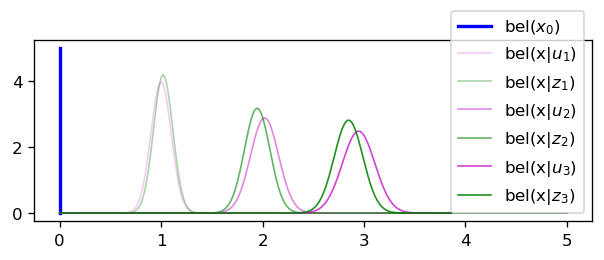

In [29]:
fig = plt.figure(figsize=(6, 2), dpi=120)
plt.plot([x0, x0], [0, 5], lw=2, label='bel($x_0$)', color='b')
for i, rec in df_bel.iterrows():
    p = normal_pdf(x, rec.mu, rec['var'])
    abbrev = f"${rec.update_type}_{rec.t}$"
    plt.plot(x, p, label=f"bel(x|{abbrev})", lw=1, 
             alpha=0.2 + 0.8 * i / n, color=colors[rec.update_type])
    
plt.legend()

## Exercise 2: An overview of ML methods

*Try to find (for example by internet search or from the book (Bishop)) at least
5 examples for learning techniques that have not been discussed in class. Describe these
techniques briefly and classify them with respect to the categories presented in the lecture.
Here are some examples of learning algorithms:*

  1. Mean-shift clustering: Unsupervised learning
  2. Perceptron algorithm: Discriminant function (Binary linear classifier)
  3. Neural Networks: Discriminative model (Non-linear classification or regression)
  4. Naive Bayes classifier: Generative model (learns joint p(x, y))
  5. Conditional Random Field (CRF): Discriminative model (structured prediction)
  6. Classification and Regression Trees: Discriminative model
  7. Linear Discriminant Analysis: Generative model (assumes Normal p(x|y))

For a detailed explanation, see the textbook Pattern Recognition and Machine
Learning by C.M. Bishop or the slides.